In [2]:
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


ModuleNotFoundError: No module named 'shap'

In [8]:
df=pd.read_csv('D:/AKSHAY/SBI hack/output.csv')

In [ ]:

def train_lightgbm(df):
    # 2. Define target and features
    target_col = 'TARGET'
    feature_cols = [c for c in df.columns if c != target_col]

    # 3. Basic preprocessing
    #   a) Identify categorical vs numeric
    cat_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 20]
    num_cols = [c for c in feature_cols if c not in cat_cols]

    #   b) Handle missing values
    #      - Numeric: fill with a sentinel
    df[num_cols] = df[num_cols].fillna(-999)

    #   c) Encode categoricals (LightGBM can take category codes directly)
    for c in cat_cols:
        df[c] = df[c].astype('category')

    # 4. Split into train/test
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # 5. Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    lgb_valid = lgb.Dataset(X_test,  label=y_test,  categorical_feature=cat_cols, reference=lgb_train)

    # 6. Set model parameters
    params = {
        'objective':        'binary',
        'metric':           'auc',
        'boosting_type':    'gbdt',
        'is_unbalance':     True,       # auto-handle class imbalance
        'learning_rate':    0.05,
        'num_leaves':       31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq':     5,
        'verbose':          -1,
        'seed':             42
    }

    # 7. Train with early stopping
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['train','valid']
    )

    # 8. Predictions & Evaluation
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 9. SHAP explainability
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Global feature importance summary
    shap.summary_plot(shap_values, X_test)

    # Transaction‐level explanation for the first test example
    shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     58461
           1       0.42      0.83      0.55      7088

    accuracy                           0.86     65549
   macro avg       0.70      0.85      0.73     65549
weighted avg       0.92      0.86      0.87     65549

Confusion Matrix:
[[50160  8301]
 [ 1179  5909]]


C:\Users\AKSHAY\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


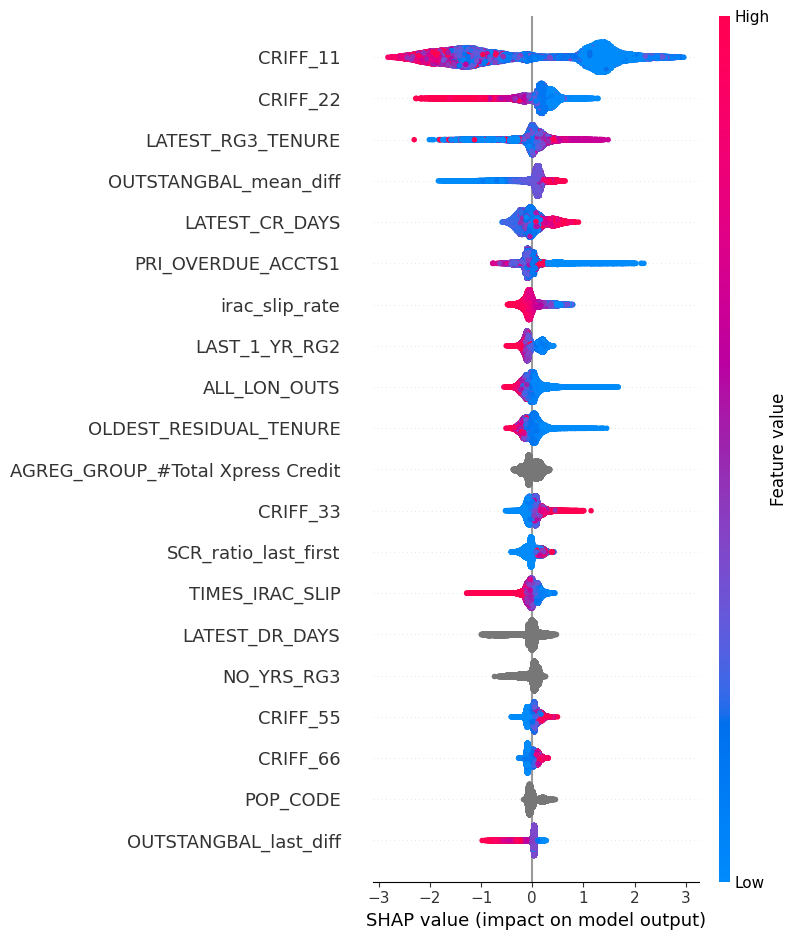

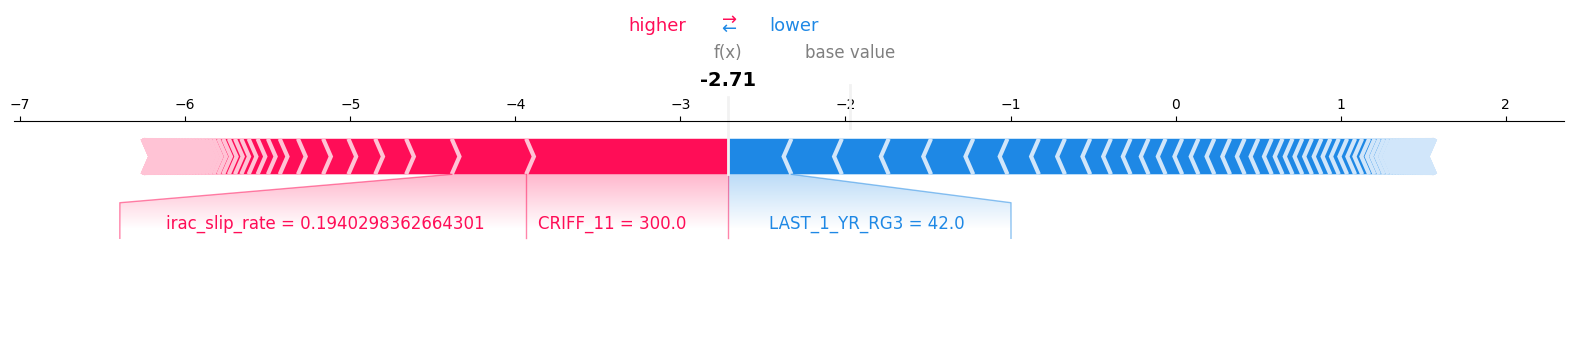

In [9]:
train_lightgbm(df)

### hyperparameter tuning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score

leaky_cols = [
    'FIRST_NPA_TENURE', 'CUST_NO_OF_TIMES_NPA', 'LATEST_NPA_TENURE', 'NO_YRS_NPA',
    'LATEST_RG3_TENURE', 'NO_YRS_RG3', 'LAST_1_YR_RG4', 'LAST_3_YR_RG4',
    'LAST_1_YR_RG3', 'LAST_1_YR_RG2', 'LAST_1_YR_RG1',
    'DEC_CRIFFCHNG1',  # this could be a post-hoc change indicator
    'TARGET'  # 'TARGET' should be kept separately, not in X
]


from sklearn.model_selection import train_test_split

# Drop leaky features and separate X and y
filtered_cols = df.drop(columns=leaky_cols)
X = filtered_cols
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [12]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score, classification_report

# === Step 1: Subsample training data for tuning (e.g., 10,000 samples) ===
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=10000, stratify=y_train, random_state=42
)

# === Step 2: Calculate scale_pos_weight on subsample ===
neg, pos = np.bincount(y_train_sub)
scale_pos_weight_sub = neg / pos
print(f"Subsample scale_pos_weight: {scale_pos_weight_sub:.2f}")

# === Step 3: Define model for tuning ===
model = LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight_sub,
    random_state=42,
    n_jobs=-1
)

# === Step 4: Define hyperparameter search space ===
param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.6, 1.0),
    'colsample_bytree': uniform(0.6, 1.0),
    'min_child_samples': randint(5, 100),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# === Step 5: Setup RandomizedSearchCV ===
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === Step 6: Run hyperparameter tuning on subsample ===
random_search.fit(X_train_sub, y_train_sub)

print("Best Hyperparameters (from subsample):")
print(random_search.best_params_)
print(f"Best CV AUC (subsample): {random_search.best_score_:.4f}")

# === Step 7: Retrain final model on full training data with best params ===
# Calculate scale_pos_weight on full training data
neg_full, pos_full = np.bincount(y_train)
scale_pos_weight_full = neg_full / pos_full
print(f"Full training scale_pos_weight: {scale_pos_weight_full:.2f}")

best_params = random_search.best_params_
best_params.update({
    'objective': 'binary',
    'scale_pos_weight': scale_pos_weight_full,
    'random_state': 42,
    'n_jobs': -1
})

final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# === Step 8: Evaluate on test data ===
y_probs = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

print(f"Test AUC: {roc_auc_score(y_test, y_probs):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Subsample scale_pos_weight: 8.25
Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\AKSHAY\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
111 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\AKSHAY\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\AKSHAY\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1560, in fit
    super().fit(
  File "C:\Users\AKSHAY\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Us

Best Hyperparameters (from subsample):
{'colsample_bytree': 0.7818249672071006, 'learning_rate': 0.02834045098534338, 'max_depth': 14, 'min_child_samples': 62, 'n_estimators': 121, 'num_leaves': 108, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'subsample': 0.7394938606520418}
Best CV AUC (subsample): 0.8622
Full training scale_pos_weight: 8.25
Test AUC: 0.9149
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     58461
           1       0.37      0.86      0.51      7088

    accuracy                           0.83     65549
   macro avg       0.67      0.84      0.70     65549
weighted avg       0.91      0.83      0.85     65549



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327741 entries, 0 to 327740
Columns: 154 entries, ACCT_AGE to frequent_irac_changes
dtypes: category(33), float64(114), int64(7)
memory usage: 312.9 MB

Missing Values:
ACCT_AGE                 0
LIMIT                    0
OUTS                     0
ACCT_RESIDUAL_TENURE     0
LOAN_TENURE              0
                        ..
loan_utilization         0
irac_slip_rate           0
loan_span                0
is_recent_loan           0
frequent_irac_changes    0
Length: 154, dtype: int64

Class Distribution:
TARGET
0    292301
1     35440
Name: count, dtype: int64

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      7106
           1       0.79      0.79      0.79      7070

    accuracy                           0.79     14176
   macro avg       0.79      0.79      0.79     14176
weighted avg       0.79      0.79      0.79     14176

ROC AUC: 0.86785

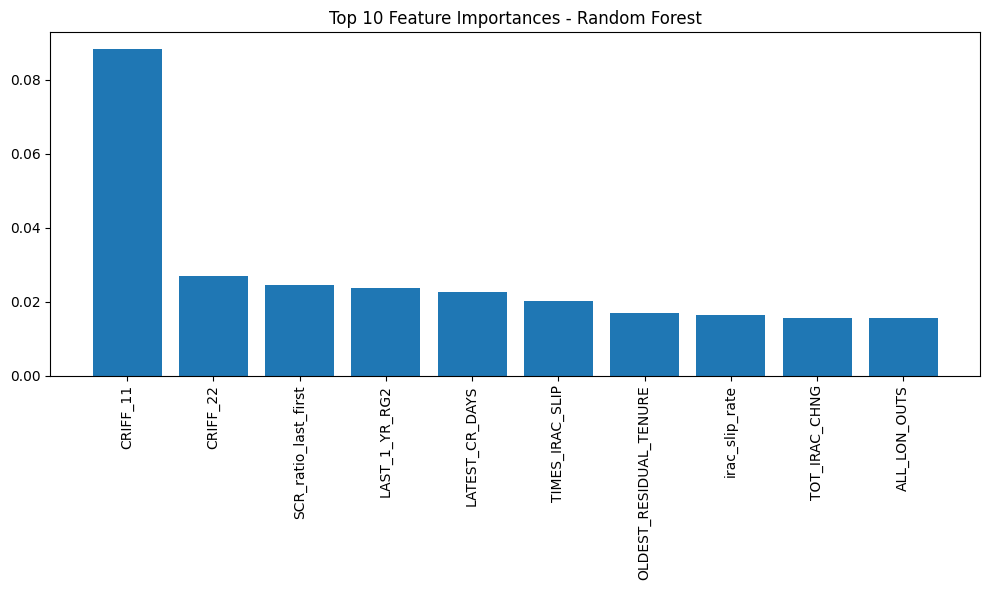

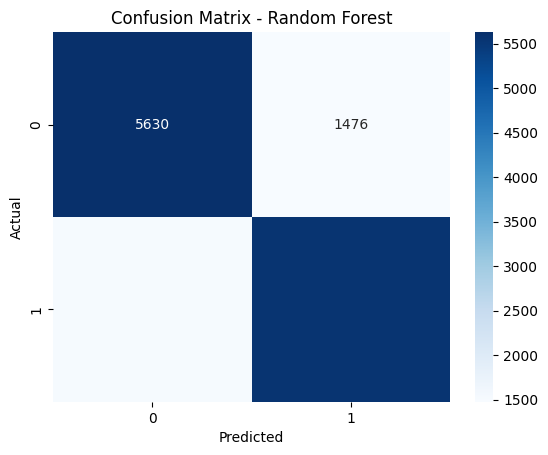

In [17]:
# Fraud Detection for SBI Hackathon - Task 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample

# 1. Load Data


# 2. Basic Info and Missing Values
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Class Balance
print("\nClass Distribution:")
print(df['TARGET'].value_counts())

# 4. Downsample Majority Class
df_majority = df[df.TARGET == 0]
df_minority = df[df.TARGET == 1]

if len(df_minority) > 0 and len(df_majority) > len(df_minority):
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,
                                       n_samples=len(df_minority),
                                       random_state=42)
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
else:
    df_balanced = df.copy()

# 5. Prepare Data for Modeling
X = df_balanced.drop("TARGET", axis=1)

# Optional: convert 'Y'/'N' to 1/0 if applicable
X = X.replace({'Y': 1, 'N': 0})

# Keep only numeric columns and fill missing values
X = X.select_dtypes(include=[np.number]).fillna(X.median(numeric_only=True))
y = df_balanced["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

# 7. Feature Importance from Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot only top 10 features
top_n = 10
plt.figure(figsize=(10,6))
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), features[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()

# 8. Confusion Matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327741 entries, 0 to 327740
Columns: 139 entries, ACCT_AGE to UNIQUE_ID
dtypes: float64(117), int64(10), object(12)
memory usage: 347.6+ MB

Missing Values:
ACCT_AGE                   0
LIMIT                      0
OUTS                       0
ACCT_RESIDUAL_TENURE      13
LOAN_TENURE                0
                        ... 
LATEST_CR_DAYS          1464
LATEST_DR_DAYS             0
TIME_PERIOD                0
TARGET                     0
UNIQUE_ID                  0
Length: 139, dtype: int64

Class Distribution:
TARGET
0    292301
1     35440
Name: count, dtype: int64


C:\Users\likit\AppData\Local\Temp\ipykernel_44080\831310673.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({'Y': 1, 'N': 0})



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     58461
           1       0.57      0.30      0.40      7088

    accuracy                           0.90     65549
   macro avg       0.74      0.64      0.67     65549
weighted avg       0.88      0.90      0.89     65549

ROC AUC: 0.8541679276122536

=== Logistic Regression ===


C:\Users\likit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.95      0.56      0.70     58461
           1       0.17      0.75      0.28      7088

    accuracy                           0.58     65549
   macro avg       0.56      0.66      0.49     65549
weighted avg       0.87      0.58      0.66     65549

ROC AUC: 0.7263814466150824


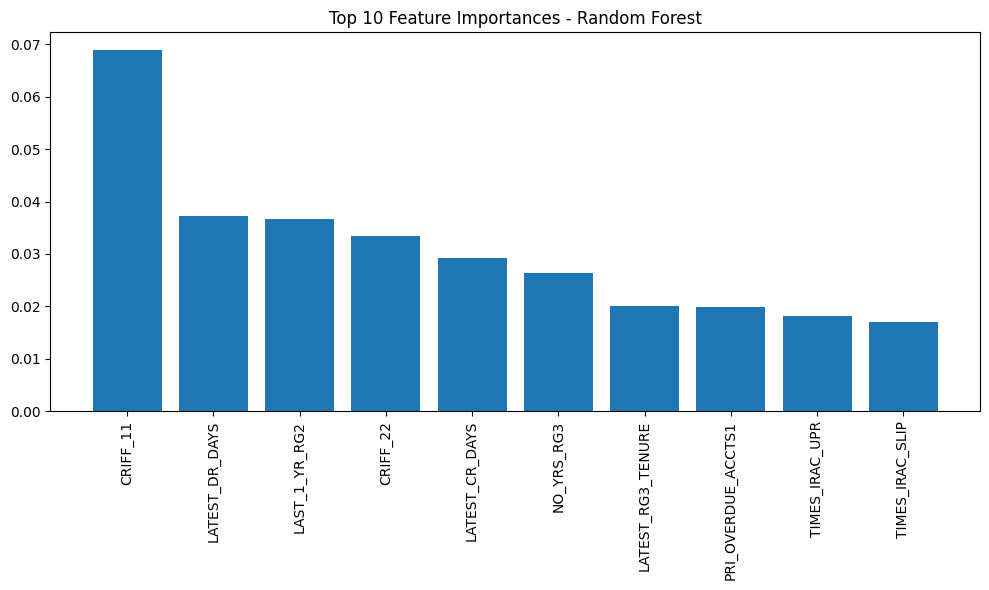

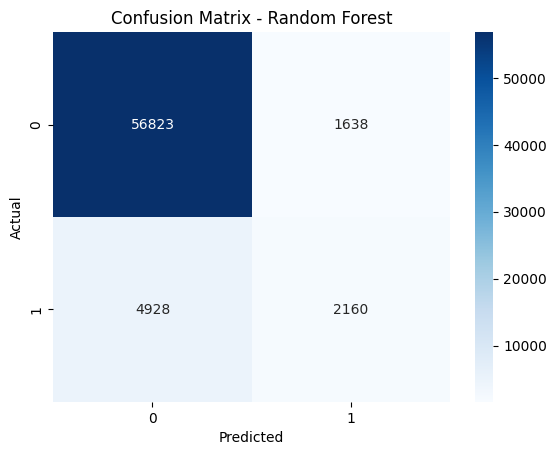

In [9]:
# Fraud Detection for SBI Hackathon - Task 1 (Extended for Larger Dataset + SMOTE + Encoding)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# 1. Load Data
df = pd.read_csv("HACKATHON_TRAINING_DATA.csv")
# 2. Basic Info and Missing Values
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Class Distribution
print("\nClass Distribution:")
print(df['TARGET'].value_counts())

# 4. Prepare Data (no downsampling, use full dataset)
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

# Optional: convert 'Y'/'N' to 1/0 if applicable
X = X.replace({'Y': 1, 'N': 0})

# Encode object/categorical columns using LabelEncoder
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Keep only numeric columns and fill missing values
X = X.select_dtypes(include=[np.number]).fillna(X.median(numeric_only=True))

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Apply SMOTE to handle class imbalance safely
minority_count = sum(y_train == 1)
sm = SMOTE(random_state=42, k_neighbors=min(2, minority_count - 1))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 7. Train Class-Weighted Models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

# 8. Feature Importance from Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot only top 10 features
top_n = 10
plt.figure(figsize=(10,6))
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), features[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()

# 9. Confusion Matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [4]:
# Fraud Detection for SBI Hackathon - Task 1 (Extended for Larger Dataset + SMOTE + Encoding)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

df = pd.read_csv("HACKATHON_TRAINING_DATA.csv")
# 2. Basic Info and Missing Values
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Class Distribution
print("\nClass Distribution:")
print(df['TARGET'].value_counts())

# 4. Prepare Data (no downsampling, use full dataset)
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

# Optional: convert 'Y'/'N' to 1/0 if applicable
X = X.replace({'Y': 1, 'N': 0})

# Encode object/categorical columns using LabelEncoder
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Keep only numeric columns and fill missing values
X = X.select_dtypes(include=[np.number]).fillna(X.median(numeric_only=True))

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Apply SMOTE to handle class imbalance safely
minority_count = sum(y_train == 1)
sm = SMOTE(random_state=42, k_neighbors=min(2, minority_count - 1))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 7. Train Class-Weighted Models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

# 8. Feature Importance from Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot only top 10 features
top_n = 10
plt.figure(figsize=(10,6))
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), features[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()

# 9. Confusion Matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Dataset Info:


NameError: name 'df' is not defined

C:\Users\likit\AppData\Local\Temp\ipykernel_44080\1753857930.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"Y": 1, "N": 0}, inplace=True)
C:\Users\likit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



=== XGBoost ===
Best Threshold (F1-optimal): 0.2900409
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95     58461
           1       0.55      0.66      0.60      7088

    accuracy                           0.90     65549
   macro avg       0.75      0.80      0.77     65549
weighted avg       0.91      0.90      0.91     65549

ROC AUC Score: 0.916594311316263
Average Precision Score: 0.6373689187249306


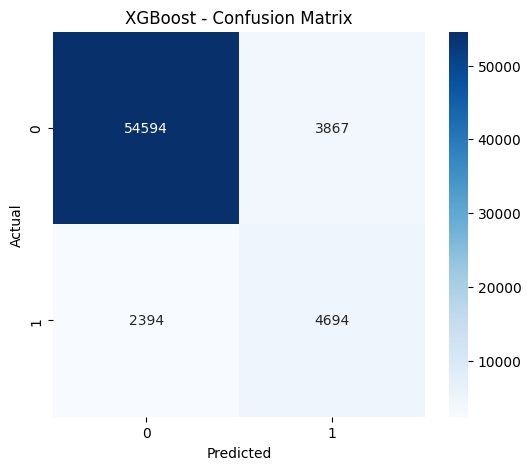

[LightGBM] [Info] Number of positive: 232215, number of negative: 232215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17827
[LightGBM] [Info] Number of data points in the train set: 464430, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM ===
Best Threshold (F1-optimal): 0.281543426997489
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     58461
           1       0.52      0.63      0.57      7088

    accuracy                           0.90     65549
   macro avg       0.74      0.78      0.76     65549
weighted avg       0.91      0.90      0.90     65549

ROC AUC Score: 0.9049859955642517
Average Precision Score: 0.6001282413902428


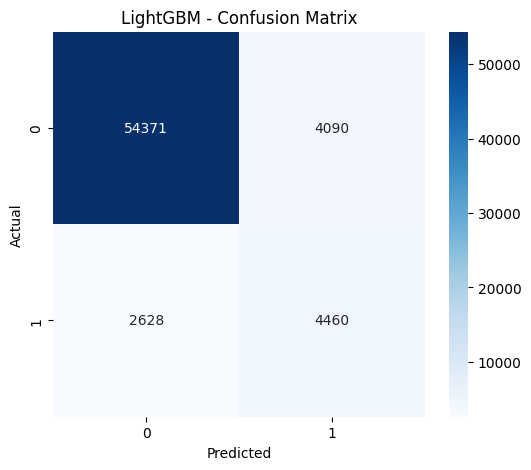

[LightGBM] [Info] Number of positive: 232215, number of negative: 232215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17827
[LightGBM] [Info] Number of data points in the train set: 464430, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 154810, number of negative: 154810
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17837
[LightGBM] [Info] Number of data points in the train set: 309620, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 154810, number of negative: 154810
[LightGBM] [Info] Auto-choosing col-wise 

C:\Users\likit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Stacked Model ===
Best Threshold (F1-optimal): 0.5846416029876229
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     58461
           1       0.25      0.51      0.33      7088

    accuracy                           0.78     65549
   macro avg       0.59      0.66      0.60     65549
weighted avg       0.86      0.78      0.81     65549

ROC AUC Score: 0.7261899107904044
Average Precision Score: 0.23898671966903517


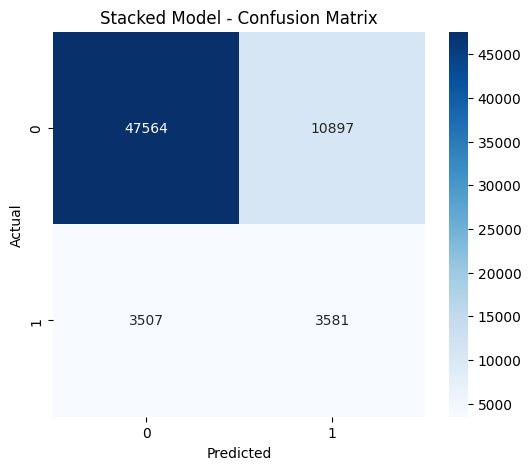

C:\Users\likit\AppData\Local\Temp\ipykernel_44080\1753857930.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=features, palette="viridis")


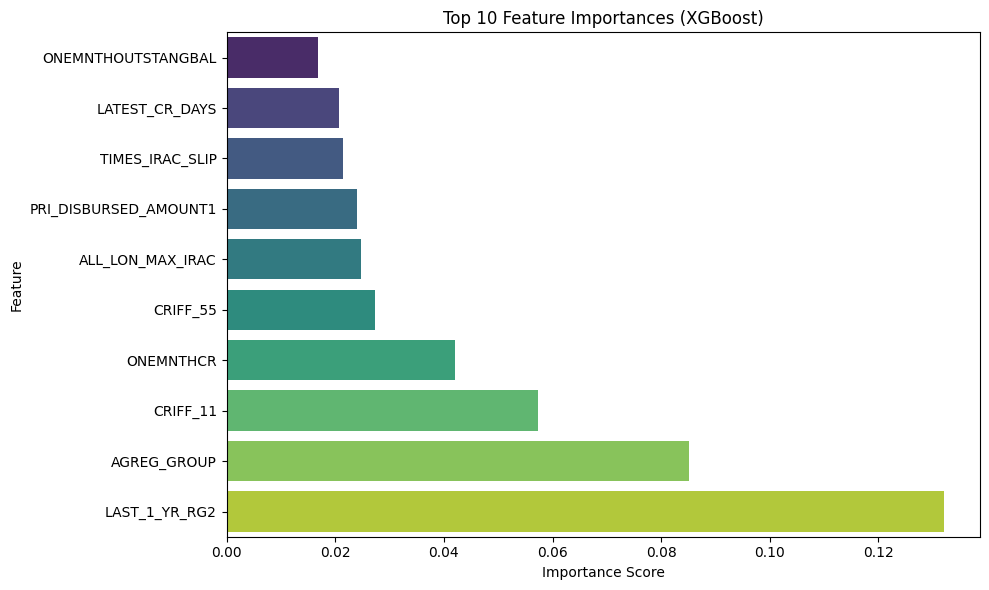

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

# Load data
df = pd.read_csv("HACKATHON_TRAINING_DATA.csv")

# Replace Y/N and infer types
df.replace({"Y": 1, "N": 0}, inplace=True)
df = df.infer_objects(copy=False)

# Feature Engineering
if 'OUTS' in df.columns and 'LIMIT' in df.columns:
    df['CREDIT_UTIL_RATIO'] = df['OUTS'] / df['LIMIT']
if 'OUTS' in df.columns and 'ACCT_AGE' in df.columns:
    df['DEBT_TENURE_RATIO'] = df['OUTS'] / df['ACCT_AGE'].replace(0, np.nan)

# Separate features and target
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

# Encode categorical columns
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Fill missing values using median imputation
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature Selection using XGBoost
xgb_selector = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_selector.fit(X, y)
selector = SelectFromModel(xgb_selector, prefit=True, threshold='median')
X_selected = selector.transform(X)
selected_cols = np.array(df.drop("TARGET", axis=1).columns)[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTETomek
resampler = SMOTETomek(random_state=42)
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

# Define and train base models
xgb = XGBClassifier(scale_pos_weight=(y_resampled == 0).sum() / (y_resampled == 1).sum(), eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)

results = {}

for name, model in [("XGBoost", xgb), ("LightGBM", lgbm)]:
    model.fit(X_resampled, y_resampled)
    y_probs = model.predict_proba(X_test)[:, 1]
    prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_threshold = thresholds[np.argmax(f1)]
    y_pred = (y_probs >= best_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"conf_matrix": cm, "threshold": best_threshold, "y_pred": y_pred}

    print(f"\n=== {name} ===")
    print("Best Threshold (F1-optimal):", best_threshold)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_probs))
    print("Average Precision Score:", average_precision_score(y_test, y_probs))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Stacked Classifier
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')
stack = StackingClassifier(
    estimators=[('xgb', xgb), ('lgbm', lgbm)],
    final_estimator=meta_model,
    passthrough=True,
    cv=3
)
stack.fit(X_resampled, y_resampled)
y_probs = stack.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_threshold = thresholds[np.argmax(f1)]
y_pred = (y_probs >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Stacked Model ===")
print("Best Threshold (F1-optimal):", best_threshold)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))
print("Average Precision Score:", average_precision_score(y_test, y_probs))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Stacked Model - Confusion Matrix")
plt.show()

# Feature Importances (Top 10 from XGB)
importances = xgb_selector.feature_importances_[selector.get_support()]
indices = np.argsort(importances)[-10:]
features = selected_cols[indices]
values = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=features, palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
